# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [3]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [4]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.434092032743436

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [10]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    results = {i:[] for i in range(0, X.shape[0])}
    
    for _ in range(num_runs):
        indexes = np.random.randint(0, X.shape[0], X.shape[0])
        pred_indexes = np.array(list(set(range(0, X.shape[0]))-set(indexes)))
        
        X_current = X[indexes, :]
        y_current = y[indexes]
        
        model = regressor
        model.fit(X_current, y_current)
        
        for i in pred_indexes:
            results[i].append(model.predict(X[i, :].reshape(1,-1)))
    
    bias = np.mean([(np.mean(results[i])- y[i])**2 for i in results.keys()])
    variance = np.mean([np.var(results[i]) for i in results.keys()])
    error = np.mean([np.mean((results[i]- y[i])**2) for i in results.keys()])
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [43]:
print(f'bias, variance and error for LinearRegression: {compute_biase_variance(LinearRegression(), X, y, num_runs=1000)}')
print(f'bias, variance and error for DecisionTreeRegressor: {compute_biase_variance(DecisionTreeRegressor(), X, y, num_runs=1000)}')
print(f'bias, variance and error for RandomForestRegressor: {compute_biase_variance(RandomForestRegressor(), X, y, num_runs=1000)}')

bias, variance andd error for LinearRegression: (23.740767672650332, 0.93787652140121, 24.678644194051547)
bias, variance andd error for DecisionTreeRegressor: (10.38394202639102, 13.158973060017514, 23.542915086408534)
bias, variance andd error for RandomForestRegressor: (10.614396032741515, 2.238984278839326, 12.85338031158084)


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ 

    Линейная модель - не очень глубокая модель, поэтому скорее всего она будет давать более сглаженные предсказания при обучении на разных данных, но при этом и неслабо отклоняясь от истинной зависимости, тем самым будет иметь пониженный разброс и повышенное смещение.

    Решающее дерево довольно сильно зависит от имеющихся данных, т.к. является гибкой моделью. Решающее дерево будет хорошо выучивать обучающие данные, из за чего будет давать не очень хорошие результаты на отложенной выборке. То есть у решающего дерева будет большой разброс. Однако, из-за того, что эта модель может обучить сложные заивисмости, решающее дерево будет иметь низкое смещение. 
    
    Random Forest - уже реализованная идея обучения решающего дерева с помощью беггинга. Также для снижения ковариации между деревьями используется случайное подмножество признаков для обучения. Тем самым, Random Forest сильно уменьшает разброс решающих деревьев. А смещение остается таким же, как у деревьев - довольно низким. 

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ Бэггинг, при отсуствии ковариации между моделями умньшает разброс в N раз, в нашем случае должен уменьшать в 1000 раз. Однако если и наблюдается уменьшение, то много меньше, чем в 1000 раз. Связано это с наличием ковариации между моделями.

In [7]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split

In [24]:
print(f'bias, variance and error for LinearRegression: {compute_biase_variance(BaggingRegressor(LinearRegression()), X, y, num_runs=1000)}')
print(f'bias, variance and error for DecisionTreeRegressor: {compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y, num_runs=1000)}')
print(f'bias, variance and error for RandomForestRegressor: {compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y, num_runs=100)}')

bias, variance and error for LinearRegression: (23.736781311132752, 1.0388093633884716, 24.77559067452122)
bias, variance and error for DecisionTreeRegressor: (10.631947331219445, 3.3509122497930974, 13.982859581012542)
bias, variance and error for RandomForestRegressor: (11.502787688477843, 1.3613780655898011, 12.864165754067642)


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [8]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    results = []
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=num_test_objects, random_state=42)
    
    for _ in range(num_runs):
        indexes = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        
        
        X_current = X_train[indexes, :]
        y_current = y_train[indexes]
        
        model = regressor
        model.fit(X_current, y_current)
        
       
        results.append(model.predict(X_test))
     
    results = np.array(results)
    plt.scatter(x = range(num_test_objects), y = y_test, color='black', s=100, label='true value')    
    for i in range(num_test_objects):
        
        plt.scatter(x = range(num_test_objects), y = results[i], color='red', s=30)
    
    results = np.array(results)
    
    plt.scatter(x = range(num_test_objects), y = np.mean(results, axis=0), color='blue', s=60, label='mean of predictions')
    plt.xlabel('number of test object')
    plt.ylabel('target values for objects')
    plt.title(f'Distribution of predictions for {title}')
    plt.legend()
    
    

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

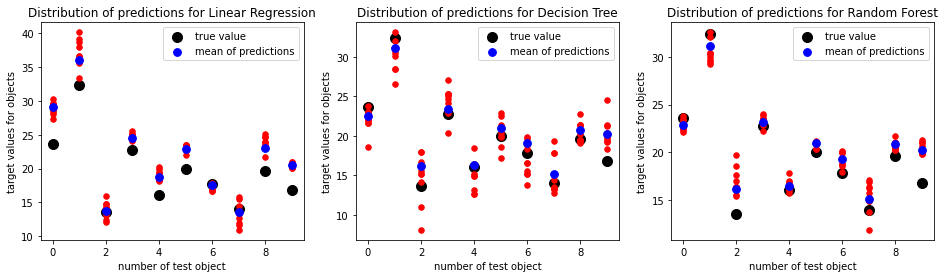

In [107]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title='Linear Regression') 
plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title='Decision Tree')
plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, title='Random Forest')

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Как можно видеть, синие точки - средние предсказания модели у линейной регресси находятся от истинных значениях довольно далеко, у решающего дерева  примерно также близко, как и у Random Forest. Это расстояние отражает смещение.
Разброс характеризует расстояние красных точек от синей. Самые большие расстояния у решающего дерева, что и обсулавливается большим разбросом.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

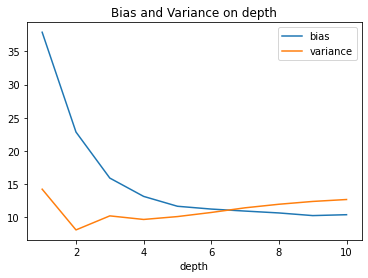

In [12]:
bias = []
variance = []
for depth in range(1, 11):
    bias_current, variance_current, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y, num_runs=1000)
    bias.append(bias_current)
    variance.append(variance_current)
plt.plot(range(1,11), bias, label='bias')
plt.plot(range(1,11), variance, label='variance')
plt.title('Bias and Variance on depth')
plt.xlabel('depth')
plt.legend()
plt.show()

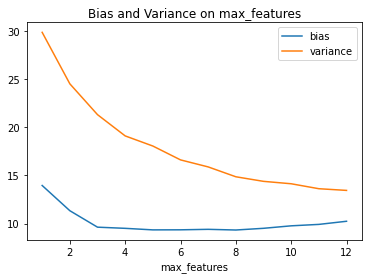

In [13]:
bias = []
variance = []
for feats in range(1, X.shape[1]):
    bias_current, variance_current, _ = compute_biase_variance(DecisionTreeRegressor(max_features=feats), X, y, num_runs=1000)
    bias.append(bias_current)
    variance.append(variance_current)
plt.plot(range(1,X.shape[1]), bias, label='bias')
plt.plot(range(1,X.shape[1]), variance, label='variance')
plt.title('Bias and Variance on max_features')
plt.xlabel('max_features')
plt.legend()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

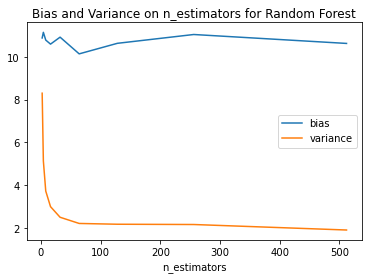

In [19]:
bias = []
variance = []
numbers = 2**np.arange(1, 10)
for num in numbers:
    bias_current, variance_current, _ = compute_biase_variance(RandomForestRegressor(n_estimators=num), 
                                                               X, y, num_runs=100)
    bias.append(bias_current)
    variance.append(variance_current)
plt.plot(numbers, bias, label='bias')
plt.plot(numbers, variance, label='variance')
plt.title('Bias and Variance on n_estimators for Random Forest')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

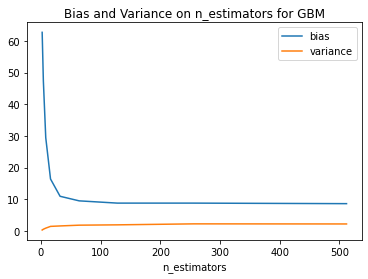

In [22]:
bias = []
variance = []
for num in numbers:
    bias_current, variance_current, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=num), 
                                                               X, y, num_runs=100)
    bias.append(bias_current)
    variance.append(variance_current)
plt.plot(numbers, bias, label='bias')
plt.plot(numbers, variance, label='variance')
plt.title('Bias and Variance on n_estimators for GBM')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

   **1 график**. При увеличении максимальной глубины дерево способно выучивать более сложные зависимости, поэтому смещение падает, однако дерево все более склонно к переобучению, поэтому variance растет.
    
   **2 график**. При недостаточном количестве доступных признаков, используемых для разбиения, дерево будет очень зависеть от данных, предоставляемых для обучения, т.к. модель хорошо подстроится под целевую переменную, сильно дробя признак, тем самым обобщающая способность модели упадет. Тем самым, даже на одном признаке модель даст не очень высокое смещение, при большом разбросе. При увеличения количества признаков модель сможет лучше подстроиться под сложную зависимость и разделит признаковое пространство более однородно, тем самым уменьшая variance и bias.
   
   **3 график** Чем меньше n_estimators, тем меньше эффект от агрегирования деревьев, то есть тем меньше падает variance в сравнении с обычным деревом, при этом bias остается примерно таким же, так как от агрегирования моделей bias не меняется.
   
   **4 график** Чем больше последовательных моделей в ансамбле, тем меньше смещение из-за усложнения ансамбля, при этом variance возрастает в случае переобучения, однако на каком-то этапе деревья в градиентном бустинге перестали приносить пользу ансамблю из-за чего variance и bias зафиксировались.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__